# Document Embeddings Experimentation (incomplete)

In [20]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, Dropout, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint


# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# uncomment to load
with gzip.open('data/poetry_umbrella_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [22]:
corpus = df.string_titled

#### The following code was taken from Radim Rehurek's Doc2Vec tutorial: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

In [23]:
def read_corpus(corpus, tokens_only=False):
    for i, line in enumerate(corpus):
        tokens = simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield TaggedDocument(tokens, [i])

corpus = df.string_titled
train_corpus = list(read_corpus(corpus))
test_corpus = list(read_corpus(corpus, tokens_only=True))

In [104]:
model = Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [105]:
model.build_vocab(train_corpus)

In [106]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [29]:
vector = model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])
print(vector)

[ 2.39920735e-01  2.49027416e-01 -3.27239782e-01 -3.16978663e-01
  1.05195999e-01  1.51303917e-01 -4.06186649e-04  2.81212837e-01
 -4.78550941e-01 -2.10875541e-01  3.78721207e-02 -6.16966903e-01
 -3.18642855e-01  3.60517442e-01  3.79602075e-01 -2.43718013e-01
  4.07453448e-01 -9.22619700e-02 -1.08814165e-02 -4.83257920e-01
 -4.01012719e-01 -2.74832547e-01 -1.30726188e-01 -1.89521968e-01
  4.93177205e-01 -1.04212977e-01 -1.86350018e-01  1.91059604e-01
  3.50649208e-01  5.64877272e-01 -7.32415468e-02  1.17919669e-01
  1.40775621e-01  1.77721977e-02  1.40548691e-01  2.26941302e-01
 -5.65813541e-01 -1.37368189e-02  2.90861279e-01 -2.81619042e-01
  2.01779604e-01  3.13947350e-01 -8.43543261e-02 -1.17663339e-01
  2.01164726e-02 -4.63801831e-01 -1.19764253e-01  7.36372396e-02
  2.46157199e-01  1.51011944e-01]


In [30]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [31]:
counter = Counter(ranks)
print(counter)

Counter({0: 4315, 1: 59, 2: 2})


In [33]:
print(f'Document ({doc_id}): «{" ".join(train_corpus[doc_id].words)}»\n')
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (4375): «the ballad of reading gaol he did not wear his scarlet coat for blood and wine are red and blood and wine were on his hands when they found him with the dead the poor dead woman whom he loved and murdered in her bed he walked amongst the trial men in suit of shabby gray cricket cap was on his head and his step seemed light and gay but never saw man who looked so wistfully at the day never saw man who looked with such wistful eye upon that little tent of blue which prisoners call the sky and at every drifting cloud that went with sails of silver by walked with other souls in pain within another ring and was wondering if the man had done great or little thing when voice behind me whispered low that fellow got to swing dear christ the very prison walls suddenly seemed to reel and the sky above my head became like casque of scorching steel and though was soul in pain my pain could not feel only knew what hunted thought quickened his step and why he looked upon the garish 

In [35]:
# Pick a random document from the corpus and infer a vector from the model
import random
doc_id = random.randint(0, len(train_corpus) - 1)

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(train_corpus[sim_id[0]].words)))

Train Document (3571): «to his lady beloved beauty who inspires love in me from afar your face obscured except when your celestial image stirs my heart in sleep or in the fields where light and nature laughter shine more lovely was it maybe you who blessed the innocent age called golden and do you now blithe spirit fly among men or does that miser fate who hides you from us save you for the future no hope of seeing you alive remains for me now except when naked and alone my soul will go down new street to its unknown home already at the dawn of my dark uncertain day imagined you fellow traveler on this arid ground but there no thing that resembles you on earth and if someone had face like yours in act and word she be though something like you far less beautiful in spite of all the suffering fate decreed for human time if there were anyone on earth who truly loved you as my thought depicts you this life for him would be blessing and see clearly how your love would lead me still to striv

In [36]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (715): «from the garden come my beloved consider the lilies we are of little faith we talk too much put your mouthful of words away and come with me to watch the lilies open in such field growing there like yachts slowly steering their petals withour nurses or clocks let us consider the view white house where white clouds decorate the muddy halls oh put away your good words and your bad words spit out your words like stones come here come here come eat my pleasant fruits»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc2,s0.001,t3):

MOST (715, 0.9580572247505188): «from the garden come my beloved consider the lilies we are of little faith we talk too much put your mouthful of words away and come with me to watch the lilies open in such field growing there like yachts slowly steering their petals withour nurses or clocks let us consider the view white house where white clouds decorate the muddy halls oh put away your good words and your bad words spit out your

In [37]:
corpus = df.string_titled

#### The following code was taken from Radim Rehurek's Doc2Vec tutorial: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

In [49]:
from string import punctuation, digits

In [50]:
def read_corpus2(corpus, tokens_only=False):
    for i, poem in enumerate(corpus):
        tokens = poem.translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits))\
                     .lower().split()
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield TaggedDocument(tokens, [i])

train_corpus = list(read_corpus2(corpus))
test_corpus = list(read_corpus2(corpus, tokens_only=True))

In [52]:
model = Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [53]:
model.build_vocab(train_corpus)

In [54]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [55]:
vector = model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])
print(vector)

[ 0.3641323   0.4426872  -0.24515273 -0.06211951  0.04638768 -0.04779288
  0.1092745   0.17387581  0.13596193 -0.18581066 -0.17833018 -0.54416656
 -0.38166133  0.11315519 -0.01222309 -0.25118425  0.50365055  0.04369404
 -0.00330478 -0.43215257 -0.54307526 -0.18391082 -0.62682384 -0.07641267
  0.1715149  -0.31349722  0.17195982  0.17389297  0.37865847  0.23746067
  0.09999489  0.25249752 -0.00937029 -0.22465402  0.21070032  0.4254049
 -0.50899094  0.3332064   0.18122652 -0.21273501 -0.0075468   0.2606
  0.18914218 -0.23635219  0.03237567 -0.18837589 -0.06564376  0.12408153
 -0.00135793 -0.01070736]


In [56]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [57]:
counter = Counter(ranks)
print(counter)

Counter({0: 4319, 1: 51, 2: 6})


In [58]:
print(f'Document ({doc_id}): «{" ".join(train_corpus[doc_id].words)}»\n')
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (4375): «the ballad of reading gaol he did not wear his scarlet coat for blood and wine are red and blood and wine were on his hands when they found him with the dead the poor dead woman whom he loved and murdered in her bed he walked amongst the trial men in a suit of shabby gray a cricket cap was on his head and his step seemed light and gay but i never saw a man who looked so wistfully at the day i never saw a man who looked with such a wistful eye upon that little tent of blue which prisoners call the sky and at every drifting cloud that went with sails of silver by i walked with other souls in pain within another ring and was wondering if the man had done a great or little thing when a voice behind me whispered low that fellows got to swing dear christ the very prison walls suddenly seemed to reel and the sky above my head became like a casque of scorching steel and though i was a soul in pain my pain i could not feel i only knew what hunted thought quickened his step and

In [59]:
# Pick a random document from the corpus and infer a vector from the model
import random
doc_id = random.randint(0, len(train_corpus) - 1)

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(train_corpus[sim_id[0]].words)))

Train Document (342): «a wicker basket comes the time when it’s later and onto your table the headwaiter puts the bill and very soon after rings out the sound of lively laughter— picking up change hands like a walrus and a face like a barndoor’s and a head without any apparent size nothing but two eyes— so that’s you man or me i make it as i can i pick up i go faster than they know— out the door the street like a night any night and no one in sight but then well there she is old friend liz— and she opens the door of her cadillac i step in back and we’re gone she turns me on— there are very huge stars man in the sky and from somewhere very far off someone hands me a slice of apple pie with a gob of white white ice cream on top of it and i eat it— slowly and while certainly they are laughing at me and all around me is racket of these cats not making it i make it in my wicker basket»

Similar Document (2732, 0.6498358845710754): «the instruction manual as i sit looking out of a window of 

In [60]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (659): «epitaph for fire and flower you might as well string up this wave’s green peak on wire to prevent fall or anchor the fluent air in quartz as crack your skull to keep th pe erishable i that will kindle angels’ envy scorch and drop their fond hearts charred as any match seek no stony cameraeye to fix the passing dazzle of each face in black and white or put on ice mouth’s instant flare for future looks stars shoot their ne and suns run to seed however you ma’ hold h darli ig wrecks hived like honey in your head»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc2,s0.001,t3):

MOST (659, 0.9573489427566528): «epitaph for fire and flower you might as well string up this wave’s green peak on wire to prevent fall or anchor the fluent air in quartz as crack your skull to keep th pe erishable i that will kindle angels’ envy scorch and drop their fond hearts charred as any match seek no stony cameraeye to fix the passing dazzle of each face in black and white or 

#### The following code was modeled after work by Aaron Abrahamson: https://towardsdatascience.com/creating-a-brewery-recommender-with-doc2vec-15ca20e28e7a

In [120]:
# Instantiate a Doc2Vec model
model = Doc2Vec(dm=0, dbow_words=1, min_count=2, negative=3,
                hs=0, sample=1e-4, window=5, size=100, workers=8)
# Build the vocab from the tagged documents
model.build_vocab(train_corpus, progress_per=100)
# Train the model from the tagged documents
model.train(train_corpus, total_examples=model.corpus_count, epochs=40)

In [70]:
# Search based on a keyword
vec = model['cloud']
similar_poems = model.docvecs.most_similar([vec], topn=100)

In [91]:
model.docvecs.doctag_syn0norm

array([[ 0.10418506,  0.18514542,  0.0853777 , ..., -0.06551975,
        -0.02672108, -0.00370485],
       [ 0.01785736,  0.18750626,  0.11602147, ..., -0.05683407,
        -0.11724914,  0.01856944],
       [ 0.10980868,  0.17109771,  0.12887168, ..., -0.07940262,
        -0.03980361, -0.0064964 ],
       ...,
       [ 0.01732862,  0.17598747,  0.15652373, ..., -0.06346416,
         0.02239993,  0.04622248],
       [ 0.05052926,  0.14854091,  0.17394492, ..., -0.05096886,
        -0.00918183, -0.04720152],
       [-0.08216993, -0.01254973, -0.2018873 , ..., -0.20762704,
        -0.08939829, -0.22688967]], dtype=float32)

In [90]:
len(model.docvecs.doctag_syn0norm)

4376

In [125]:
# load lookup dictionary pickle file
file = open('/Users/p.szymo/Documents/python_poetry/custom_corpus_streams/writings/still_streaming_v3.txt', 'r')
mine_poem = file.read()
print(mine_poem)

enter					a stream turns					into a sidewalk concrete ideas

blocking one after an					other so do it walk					on it

past the restaurants					 and stores					for the rich

maybe taste one dish					to see what you’re missing

and move on					to fantasize					about wealth and feel

shitty unable					to provide for yourself					and an other

think up					ways to make money					flow and feel shitty

about even					the thought drink slowly					and ponder from

a cheap store bought					can feels subsidized

cheapen your drunk to stare					at the concrete					stream pounding pavement

to reach some higher level					but reason calls it quikrete					reason being one sticks and drowns

solid down into					permanence state					or some prefer dreaming					and have a time believing

while others let					the practical particles cling					and drag

it’s much more difficult					to go where nowhere doesn’t exist					being from such

says someone partially respected					who wholly should					be fully b

In [127]:
mine_words = mine_poem.strip().split()

In [135]:
vec

array([-0.07860172,  0.03923923,  0.20593645,  0.13974729,  0.07490428,
        0.36328706, -0.17560968,  0.17241295,  0.15238874, -0.20241147,
        0.29613513, -0.26847905,  0.3127078 ,  0.06229842, -0.0138291 ,
        0.07508605, -0.01654086, -0.02726972, -0.06466588,  0.21283072,
        0.06261549, -0.03225867, -0.08189702, -0.03346299,  0.03675763,
       -0.2227456 , -0.03255509,  0.09249134,  0.0125851 ,  0.28811333,
        0.02302   ,  0.08361639,  0.10744103, -0.1680767 ,  0.18534464,
       -0.0482998 , -0.46762276,  0.01007872, -0.02839535, -0.29556236,
       -0.39791957,  0.00118425,  0.16458768, -0.1109432 , -0.480207  ,
       -0.38318986, -0.23354697,  0.04221218,  0.13627654, -0.34352377,
        0.22963329,  0.22022873, -0.3215615 ,  0.24316244, -0.2999786 ,
       -0.08892182,  0.40278527,  0.10802142,  0.1747155 , -0.02406783,
       -0.23351918, -0.12426955,  0.08407553, -0.13933274, -0.01370586,
       -0.19859083, -0.07265055,  0.18376392,  0.21907243,  0.12

In [132]:
mine_words = mine_poem.strip().split()
vector = model.infer_vector(mine_words)

In [134]:
vector

array([-0.04913487,  0.77804124,  0.6623756 ,  0.15515152,  0.30789405,
        0.13043305, -0.0924789 ,  0.88194454,  0.05075281, -0.71980125,
       -0.10968938,  0.08784829, -0.57428914,  0.30247808,  0.39622632,
       -0.47834206, -0.32857108,  0.10381709,  0.15125556,  0.38476247,
       -0.28984728, -0.06150966,  0.28440624, -0.30072787,  0.3013655 ,
        0.4297333 ,  0.6561163 ,  0.10434704, -0.4419173 ,  0.00831939,
       -0.09507431,  0.1597735 , -0.02793267, -0.10541551,  0.18535799,
        0.2007814 ,  0.19376644,  0.8067562 ,  0.06653541, -0.7258914 ,
       -0.26772776,  0.37880722, -0.09174444,  0.08432625,  0.18548903,
       -0.10332076, -0.17400543,  1.014883  , -0.5905214 ,  0.19213116,
       -0.18069112,  0.12228477,  0.47876114, -0.06117044, -0.17401665,
        0.26313254,  0.4818507 , -0.3554245 , -0.02664561,  0.29665893,
        0.3169722 , -0.19467986, -0.51802164, -0.31696317,  0.21263896,
       -0.46608475,  0.5919807 , -0.29144183,  0.08874776,  0.29

In [148]:
print(df.loc[5, 'poem_string'])

I feel horrible. She doesn’t
 love me and I wander around
 the house like a sewing machine
 that’s just finished sewing
 a turd to a garbage can lid.



In [146]:
df.loc[172]

poet_url                                                                                                                          https://www.poetryfoundation.org/poets/amiri-baraka
genre                                                                                                                                                             black_arts_movement
poem_url                                                                                                    https://www.poetryfoundation.org/poetrymagazine/poems/29929/like-rousseau
poet                                                                                                                                                                     Amiri Baraka
title                                                                                                                                                                   Like Rousseau
poem_lines                      [She stands beside me, stands away,   , \r the vague indif

In [137]:
mine_words = mine_poem.strip().split()
vector = model.infer_vector(mine_words)
model.docvecs.most_similar([vector], topn=100)

[(1279, 0.5283425450325012),
 (135, 0.4909302294254303),
 (1280, 0.4830920100212097),
 (172, 0.480058878660202),
 (2616, 0.4743014872074127),
 (3074, 0.47380125522613525),
 (360, 0.47369930148124695),
 (1425, 0.4733288288116455),
 (383, 0.46353304386138916),
 (544, 0.4552725851535797),
 (3166, 0.45505470037460327),
 (2994, 0.4477693736553192),
 (349, 0.44662564992904663),
 (392, 0.4458269476890564),
 (1299, 0.44425439834594727),
 (2473, 0.44399145245552063),
 (403, 0.4432324767112732),
 (1404, 0.44295209646224976),
 (1274, 0.4412344694137573),
 (681, 0.4408523738384247),
 (1298, 0.43920964002609253),
 (1290, 0.4384898543357849),
 (391, 0.43736380338668823),
 (2936, 0.43719685077667236),
 (3228, 0.4367963969707489),
 (356, 0.43630826473236084),
 (348, 0.4355606436729431),
 (1307, 0.43336227536201477),
 (333, 0.4321337342262268),
 (2108, 0.4314016103744507),
 (2400, 0.4274076819419861),
 (664, 0.42690396308898926),
 (2010, 0.42520013451576233),
 (2768, 0.4208681583404541),
 (406, 0.42040

In [128]:
similar_poems = model.docvecs.most_similar(mine_words, topn=100)

TypeError: '<' not supported between instances of 'str' and 'int'

In [129]:
similar_poems

[(3460, 0.7782642841339111),
 (1448, 0.7780032157897949),
 (3648, 0.7778372168540955),
 (2616, 0.7684749364852905),
 (2407, 0.7676312923431396),
 (2599, 0.7652615308761597),
 (1956, 0.7648324966430664),
 (2971, 0.7644050121307373),
 (2086, 0.7629475593566895),
 (1903, 0.7629103064537048),
 (1677, 0.7570759057998657),
 (3618, 0.756590723991394),
 (4046, 0.7523409724235535),
 (27, 0.7510698437690735),
 (3605, 0.7494422197341919),
 (3928, 0.7481414079666138),
 (2237, 0.7468701601028442),
 (3953, 0.7461907863616943),
 (2401, 0.7452977299690247),
 (1555, 0.7452073097229004),
 (3917, 0.7445351481437683),
 (3607, 0.7436457872390747),
 (4057, 0.7432200908660889),
 (2383, 0.743165135383606),
 (1857, 0.7430007457733154),
 (2477, 0.7426257729530334),
 (2445, 0.7424639463424683),
 (2525, 0.7424503564834595),
 (4348, 0.7422258257865906),
 (3934, 0.7418242692947388),
 (469, 0.7414809465408325),
 (918, 0.7387317419052124),
 (1921, 0.7381760478019714),
 (3651, 0.73771071434021),
 (2298, 0.737682640552

In [77]:
print(df.loc[27])

poet_url                                                                                                                       https://www.poetryfoundation.org/poets/william-everson
poem_url                                                                                                 https://www.poetryfoundation.org/poetrymagazine/poems/21675/we-in-the-fields
poet                                                                                                                                                                  William Everson
title                                                                                                                                                                We In The Fields
poem_lines                      [Dawn and a high film, the sun burned it,, , But noon had a thick sheet, and the clouds coming,, , The low rain-bringers, trooping in from the nor...
poem_string                     Dawn and a high film, the sun burned it,\n\nBut noon had a

In [71]:
similar_poems

[(3460, 0.7782642841339111),
 (1448, 0.7780032157897949),
 (3648, 0.7778372168540955),
 (2616, 0.7684749364852905),
 (2407, 0.7676312923431396),
 (2599, 0.7652615308761597),
 (1956, 0.7648324966430664),
 (2971, 0.7644050121307373),
 (2086, 0.7629475593566895),
 (1903, 0.7629103064537048),
 (1677, 0.7570759057998657),
 (3618, 0.756590723991394),
 (4046, 0.7523409724235535),
 (27, 0.7510698437690735),
 (3605, 0.7494422197341919),
 (3928, 0.7481414079666138),
 (2237, 0.7468701601028442),
 (3953, 0.7461907863616943),
 (2401, 0.7452977299690247),
 (1555, 0.7452073097229004),
 (3917, 0.7445351481437683),
 (3607, 0.7436457872390747),
 (4057, 0.7432200908660889),
 (2383, 0.743165135383606),
 (1857, 0.7430007457733154),
 (2477, 0.7426257729530334),
 (2445, 0.7424639463424683),
 (2525, 0.7424503564834595),
 (4348, 0.7422258257865906),
 (3934, 0.7418242692947388),
 (469, 0.7414809465408325),
 (918, 0.7387317419052124),
 (1921, 0.7381760478019714),
 (3651, 0.73771071434021),
 (2298, 0.737682640552

In [69]:
lookup_dict = df.to_dict(orient='index')

## Visualize

In [79]:
from sklearn.manifold import TSNE

In [171]:
doc_tags

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [178]:
model.docvecs[0]

array([ 0.16470669,  0.49908826,  0.01035163,  0.42111382, -0.20976433,
       -0.04061399, -0.02564485,  0.2862122 ,  0.082862  , -0.09447087,
        0.2263422 , -0.23946895, -0.09048069,  0.7870809 , -0.14720866,
       -0.05754693,  0.46154422, -0.16175127,  0.7134898 , -0.1226792 ,
       -0.36369005, -0.10541411,  0.12225953,  0.04070822,  0.10073316,
        0.21157919, -0.2323063 , -0.05680246,  0.16783576, -0.01184658,
       -0.40236446,  0.28598282,  0.4899267 , -0.29967782, -0.00405284,
       -0.17773587,  0.44679013,  0.46094966,  0.06461807,  0.09690885,
       -0.3961091 ,  0.23114899,  0.05768878, -0.01731164,  0.36861953,
        0.13287652, -0.12241308,  0.66270196,  0.16773832,  0.12940162,
        0.2128686 ,  0.03786785,  0.06924023, -0.3954721 , -0.2557505 ,
        0.40794942, -0.16830856, -0.3535369 , -0.14478914, -0.17385378,
       -0.36224848, -0.5653449 , -0.88190275, -0.00303622, -0.14868477,
       -0.47814798, -0.18392575,  0.13879606,  0.73614967, -0.03

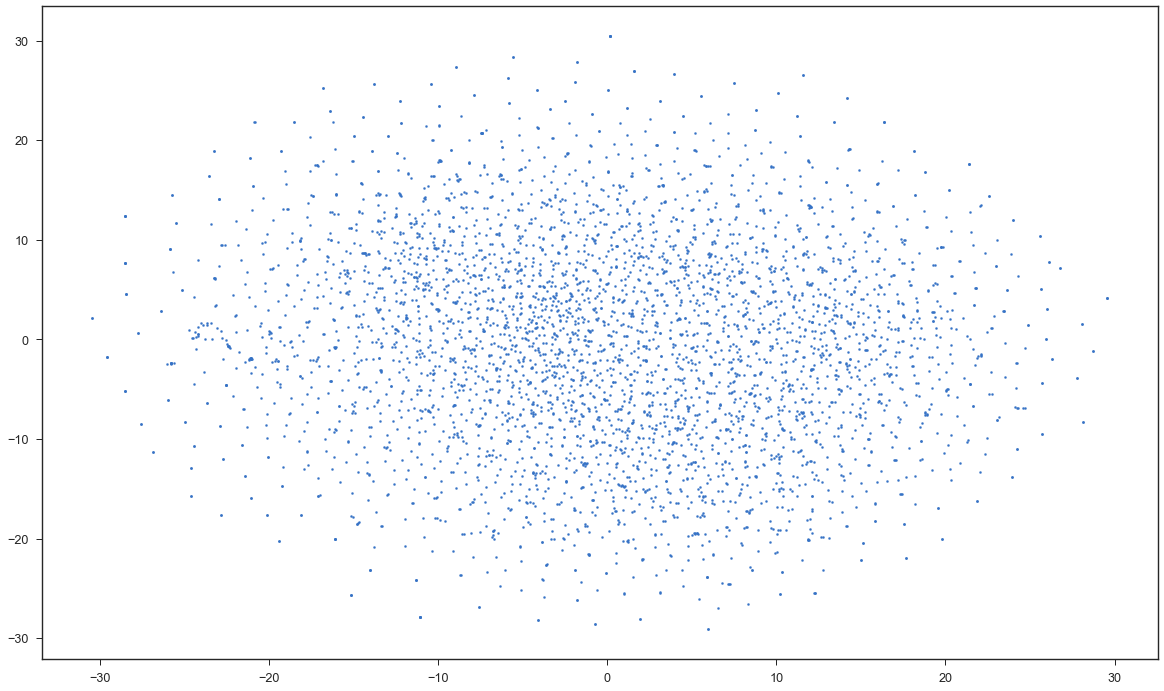

In [172]:
# doc_tags is just a list of every unique document tag/beer_id
doc_tags = [tag[1][0] for tag in train_corpus]
# get the vector for each doc_tag
X = model[doc_tags]
# Fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
# create a scatterplot of the resulting 2-dimensional data
plt.figure(figsize=(20,12))
plt.scatter(df_tsne['x'], df_tsne['y'], s=5);

In [112]:
def make_tsne_subset(tsne_df: pd.DataFrame, poetry_df: pd.DataFrame, genre: str) -> pd.DataFrame:
    """
    Takes a dataframe of a fit/transformed t-SNE object. Beer ID/Doc Tags are the index.
    Second argument is a string that is the style of beer (as per stated style in the beers dataset)
    Returns a Pandas Dataframe with t-SNE coordinates of that specific style, allowing you to show clustering
    """
    subset = poetry_df.loc[poetry_df['genre'] == genre]
    subset_set = set(subset.index)
    match = set(tsne_df.index).intersection(subset_set)
    style_subset = tsne_df[tsne_df.index.isin(match)]
    return style_subset

In [152]:
df['genre'].unique()

array(['beat', 'black_arts_movement', 'black_mountain', 'confessional',
       'fugitive', 'georgian', 'harlem_renaissance', 'imagist',
       'language_poetry', 'modern', 'new_york_school',
       'new_york_school_2nd_generation', 'objectivist', 'romantic',
       'victorian'], dtype=object)

In [163]:
train_corpus[0][1]

[0]

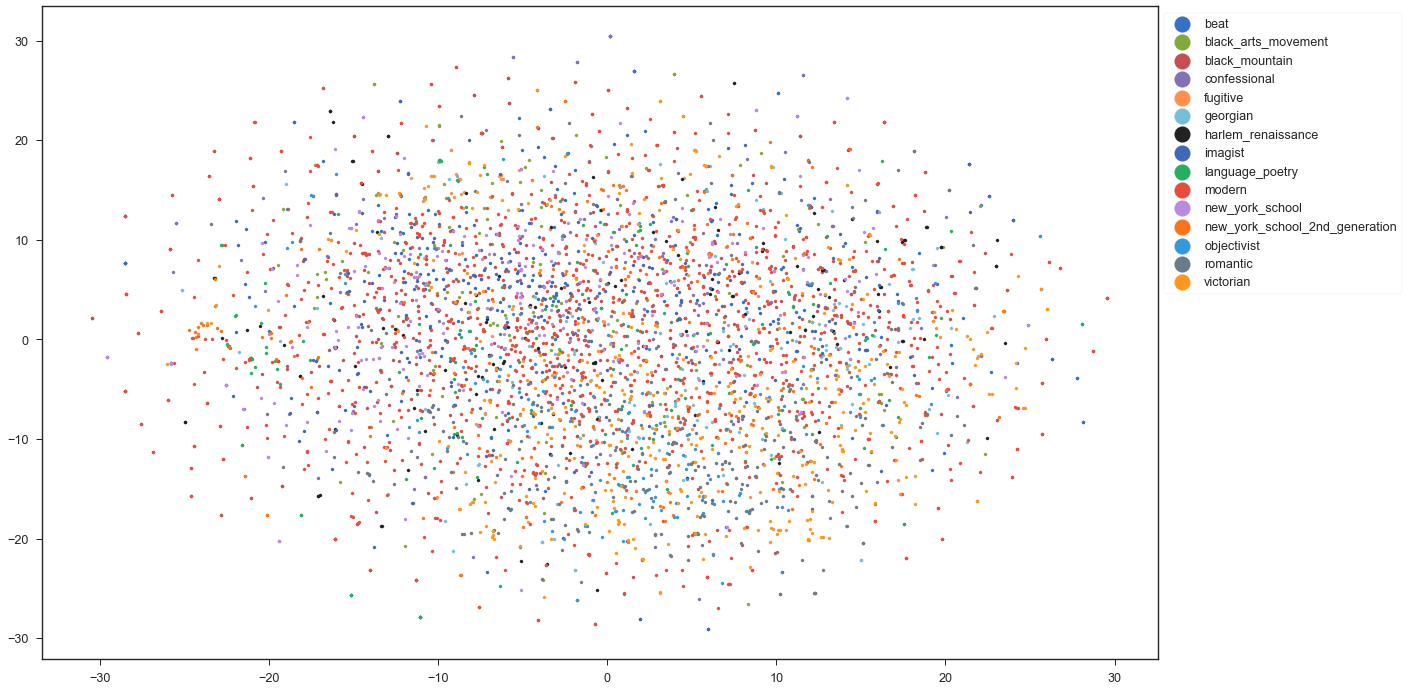

In [177]:
genres = df['genre'].unique()
# iterates through every unique beer style and plots with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=10)
ax.legend(genres, bbox_to_anchor=(1,1), markerscale=5)

In [194]:
# Instantiate a Doc2Vec model
model = Doc2Vec(min_count=3, window=5, size=100, workers=8)
# Build the vocab from the tagged documents
model.build_vocab(train_corpus)
# Train the model from the tagged documents
model.train(train_corpus, total_examples=model.corpus_count, epochs=50)

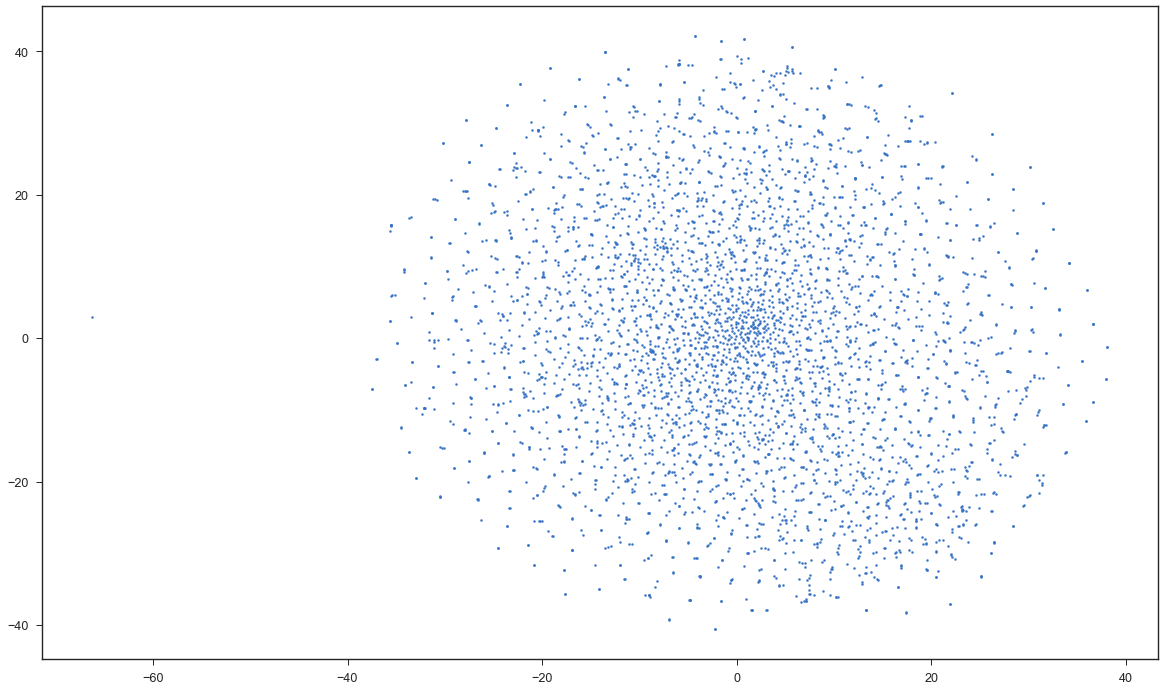

In [195]:
# doc_tags is just a list of every unique document tag/beer_id
doc_tags = [tag[1][0] for tag in train_corpus]
# get the vector for each doc_tag
X = model[doc_tags]
# Fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
# create a scatterplot of the resulting 2-dimensional data
plt.figure(figsize=(20,12))
plt.scatter(df_tsne['x'], df_tsne['y'], s=5);

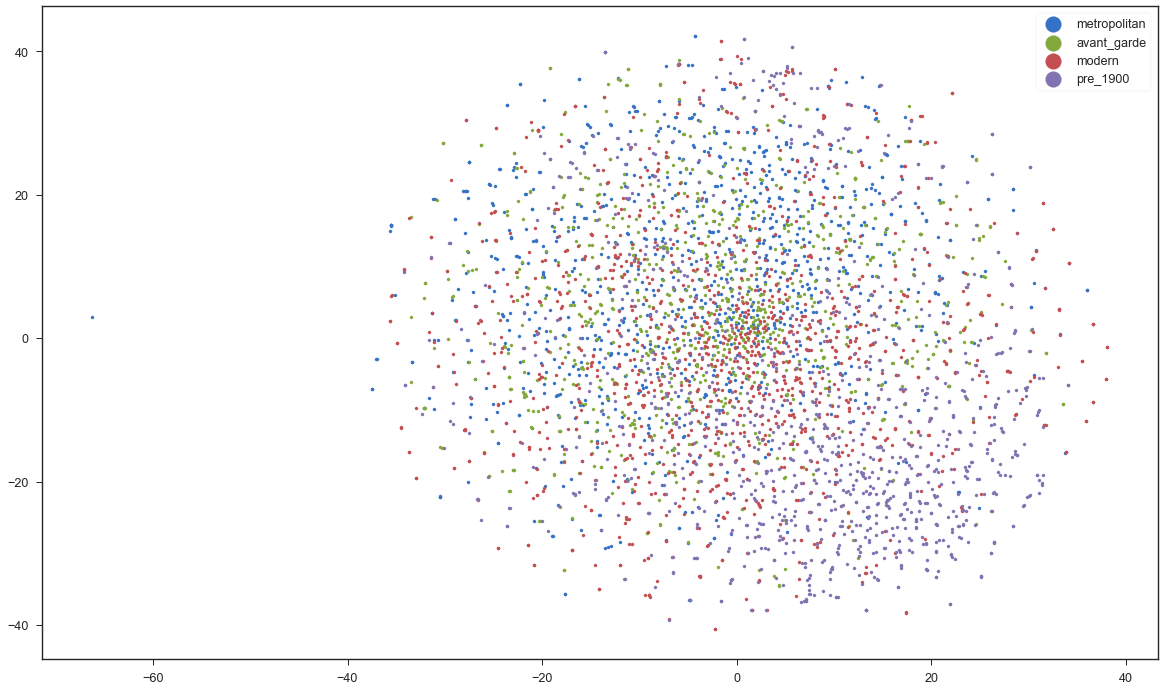

In [196]:
genres = df['genre'].unique()
# iterates through every unique beer style and plots with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=10)
ax.legend(genres, bbox_to_anchor=(1,1), markerscale=5)

In [197]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned'],
      dtype='object')

In [198]:
corpus = df.string_cleaned
train_corpus = list(read_corpus(corpus))
test_corpus = list(read_corpus(corpus, tokens_only=True))

In [199]:
# Instantiate a Doc2Vec model
model2 = Doc2Vec(min_count=3, window=5, size=100, workers=8)
# Build the vocab from the tagged documents
model2.build_vocab(train_corpus)
# Train the model from the tagged documents
model2.train(train_corpus, total_examples=model.corpus_count, epochs=50)

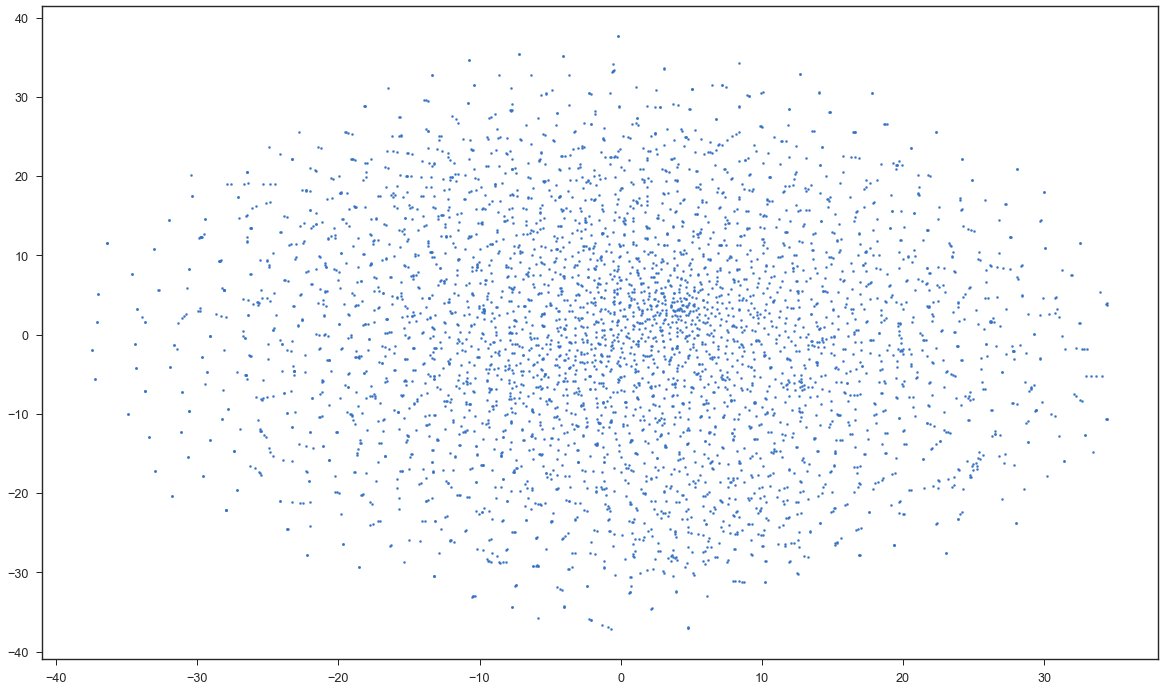

In [200]:
# doc_tags is just a list of every unique document tag/beer_id
doc_tags = [tag[1][0] for tag in train_corpus]
# get the vector for each doc_tag
X = model2[doc_tags]
# Fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
# create a scatterplot of the resulting 2-dimensional data
plt.figure(figsize=(20,12))
plt.scatter(df_tsne['x'], df_tsne['y'], s=5);

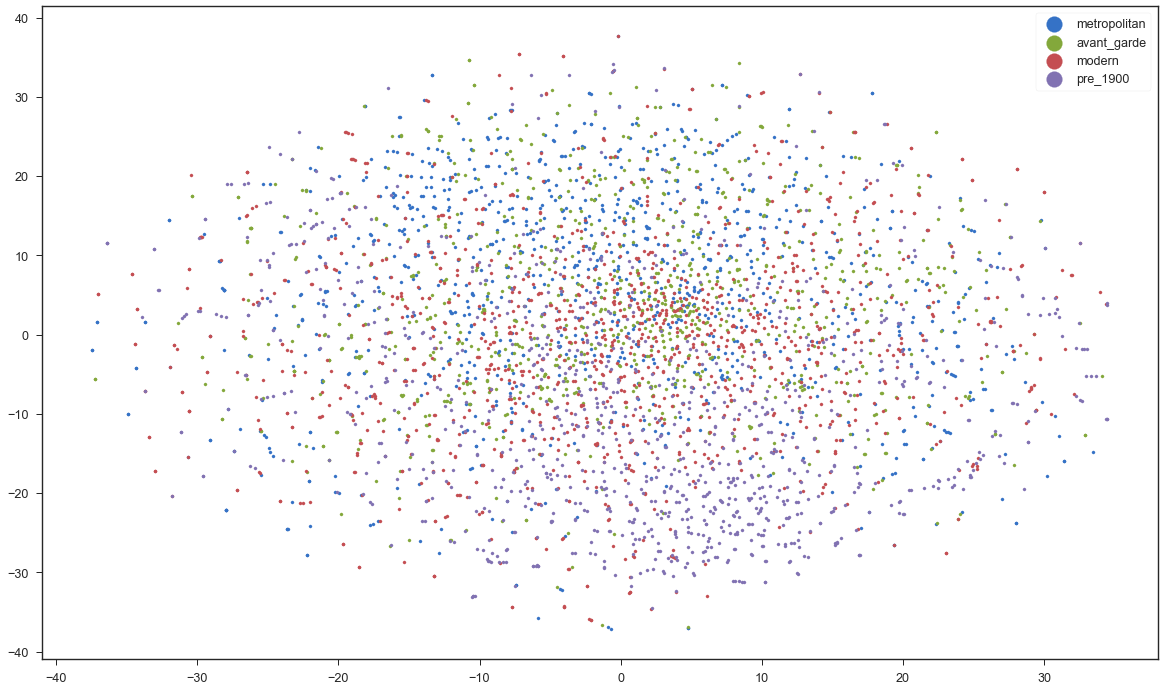

In [201]:
genres = df['genre'].unique()
# iterates through every unique beer style and plots with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=10)
ax.legend(genres, bbox_to_anchor=(1,1), markerscale=5)

In [237]:
df['doc_vec'] = [model2.docvecs[i] for i in range(len(model2.docvecs))]

In [248]:
df.loc[4000, 'doc_vec'].mean()

0.02404654

In [239]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'doc_vec'],
      dtype='object')

In [251]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffle(self.sentences)
        return self.sentences

In [252]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'doc_vec'],
      dtype='object')

In [253]:
# assign a features dataframe
X = df[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_titled']]
# assign a target variable
y = df['genre']

In [254]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3282, 7) (3282,)
(1094, 7) (1094,)


In [257]:
model = Doc2Vec(min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=8)

model.build_vocab(train_corpus)

In [259]:
# random
from random import shuffle

In [262]:
def shuffle_poems(thing):
    shuffle(thing)
    return thing

In [266]:
for epoch in range(40):
    model.train(shuffle_poems(train_corpus), total_examples=model.corpus_count, epochs=1)

In [267]:
model.most_similar('good')

[('cravan', 0.6363605856895447),
 ('sorry', 0.6347411870956421),
 ('folk', 0.6153191328048706),
 ('victual', 0.6131412982940674),
 ('coachman', 0.6116783618927002),
 ('theys', 0.6020869016647339),
 ('juggling', 0.5883652567863464),
 ('salam', 0.579741358757019),
 ('workshop', 0.579389214515686),
 ('gubernator', 0.5740789771080017)]

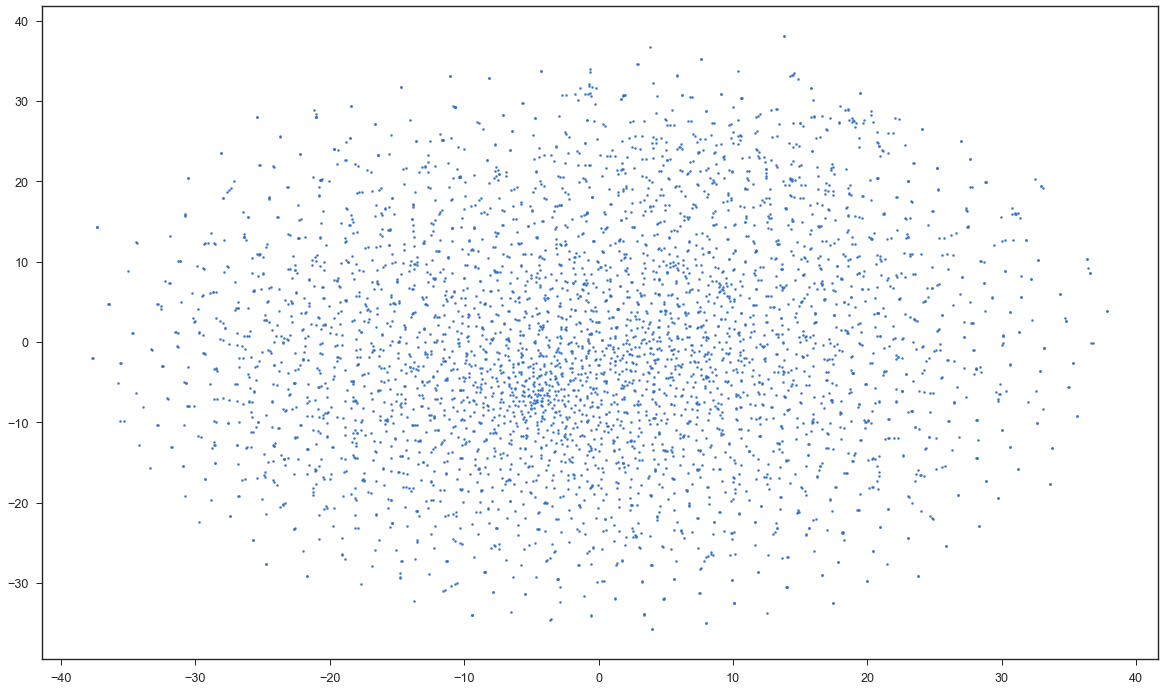

In [269]:
# doc_tags is just a list of every unique document tag/beer_id
doc_tags = [tag[1][0] for tag in train_corpus]
# get the vector for each doc_tag
X = model2[doc_tags]
# Fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
# create a scatterplot of the resulting 2-dimensional data
plt.figure(figsize=(20,12))
plt.scatter(df_tsne['x'], df_tsne['y'], s=5);

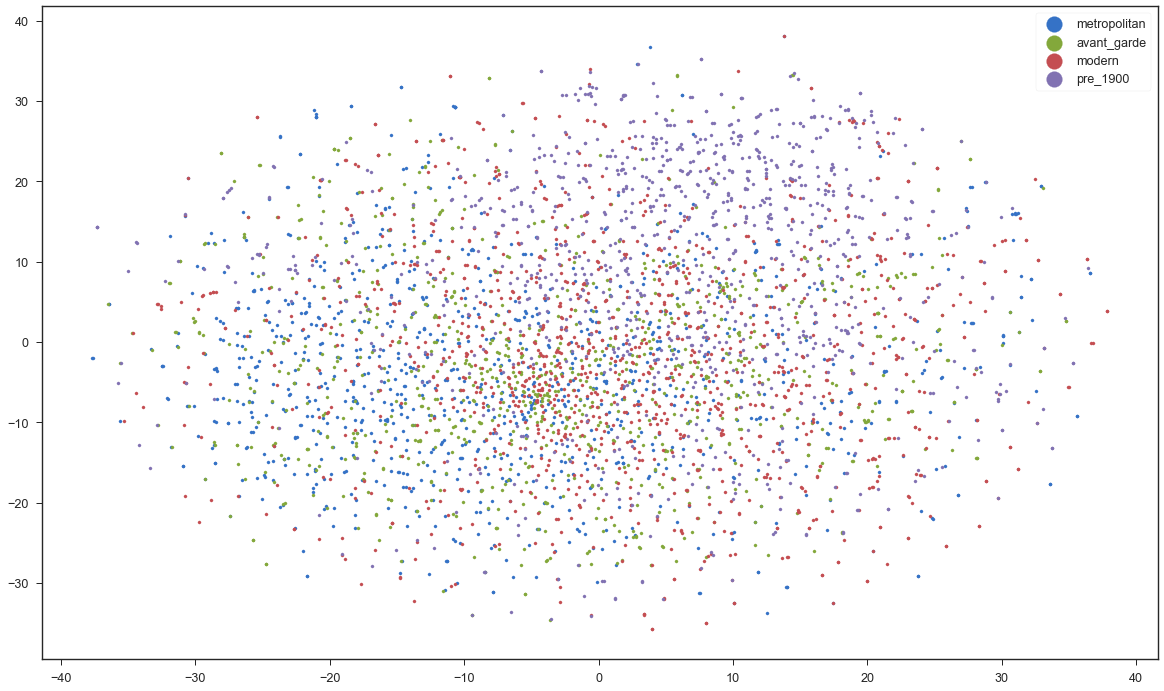

In [270]:
genres = df['genre'].unique()
# iterates through every unique beer style and plots with color
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df, genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=10)
ax.legend(genres, bbox_to_anchor=(1,1), markerscale=5)

In [271]:
# Search based on a keyword
vec = model['brick']
similar_poems = model.docvecs.most_similar([vec], topn=5)
similar_poems

[(2812, 0.6940257549285889),
 (2750, 0.6831132769584656),
 (113, 0.679733157157898),
 (1544, 0.6756721138954163),
 (2776, 0.6711874008178711)]

In [272]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'doc_vec'],
      dtype='object')

In [283]:
def word_similarity(word, num_poems=5):
    # search based on a keyword
    vec = model[word]
    similar_poems = model.docvecs.most_similar([vec], topn=num_poems)
    for i, pct in similar_poems:
        print(f'{round(pct*100,1)}% match')
        print(f'{df.loc[i,"title"].upper()} by {df.loc[i,"poet"]}')
        print(f'URL: {df.loc[i,"poem_url"]}')
        print('-'*100)

In [285]:
word_similarity('lick')

74.9% match
O MAKE ME A MASK AND A WALL by Dylan Thomas
URL: https://www.poetryfoundation.org/poetrymagazine/poems/22110/o-make-me-a-mask-and-a-wall
----------------------------------------------------------------------------------------------------
73.8% match
WHITE MALES by Robert M. McAlmon
URL: https://www.poetryfoundation.org/poetrymagazine/poems/15007/white-males
----------------------------------------------------------------------------------------------------
72.2% match
NIGHTTRAINS by Jayne Cortez
URL: https://www.poetryfoundation.org/poems/90804/nighttrains
----------------------------------------------------------------------------------------------------
71.7% match
THE EYELID HAS ITS STORMS by Frank O'Hara
URL: https://www.poetryfoundation.org/poetrymagazine/poems/26778/the-eyelid-has-its-storms
----------------------------------------------------------------------------------------------------
71.6% match
ARIEL by Sylvia Plath
URL: https://www.poetryfoundation.org/poems/

In [ ]:
mine_words = mine_poem.strip().split()
vector = model.infer_vector(mine_words)
model.docvecs.most_similar([vector], topn=100)

In [ ]:
poem.translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits))\
                     .lower().split()

In [288]:
def text_similarity(text, num_poems=5):
    # search based on a string
    words = text.translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits))\
                     .strip().lower().split()
    vector = model.infer_vector(words)
    similar_poems = model.docvecs.most_similar([vector], topn=num_poems)
    for i, pct in similar_poems:
        print(f'{round(pct*100,1)}% match')
        print(f'{df.loc[i,"title"].upper()} by {df.loc[i,"poet"]}')
        print(f'URL: {df.loc[i,"poem_url"]}')
        print('-'*100)

In [291]:
text_similarity(mine_poem)

85.0% match
THE CONDOLENCE by Ezra Pound
URL: https://www.poetryfoundation.org/poetrymagazine/poems/12665/the-condolence
----------------------------------------------------------------------------------------------------
84.7% match
DANS UN OMNIBUS DE LONDRES by Ezra Pound
URL: https://www.poetryfoundation.org/poetrymagazine/poems/13501/dans-un-omnibus-de-londres
----------------------------------------------------------------------------------------------------
83.9% match
THE WIND BLOWETH WHERE IT LISTETH by Countee Cullen
URL: https://www.poetryfoundation.org/poetrymagazine/poems/17381/the-wind-bloweth-where-it-listeth
----------------------------------------------------------------------------------------------------
83.5% match
GOOD MAN BAD WOMAN by Wallace Stevens
URL: https://www.poetryfoundation.org/poetrymagazine/poems/19837/good-man-bad-woman
----------------------------------------------------------------------------------------------------
83.2% match
"HOW CAN I KEEP MY MA

In [292]:
text_similarity('President Trump...Does It Again')

75.9% match
THE CHOICE by Ezra Pound
URL: https://www.poetryfoundation.org/poetrymagazine/poems/12784/the-choice
----------------------------------------------------------------------------------------------------
74.2% match
DULLY GUMPTIONS ADDENDUM by Ted Hughes
URL: https://www.poetryfoundation.org/poetrymagazine/poems/29012/dully-gumptions-addendum
----------------------------------------------------------------------------------------------------
73.9% match
THE BELLAIRES by Ezra Pound
URL: https://www.poetryfoundation.org/poetrymagazine/poems/12924/the-bellaires
----------------------------------------------------------------------------------------------------
73.9% match
FOLKS WHO KNOCK AT MADAMS DOOR by Langston Hughes
URL: https://www.poetryfoundation.org/poetrymagazine/poems/23640/folks-who-knock-at-madams-door
----------------------------------------------------------------------------------------------------
73.6% match
ON COWEE RIDGE by Jonathan Williams
URL: https://www.

In [298]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'doc_vec'],
      dtype='object')

In [302]:
df[df['title'] == 'On Cowee Ridge'].string_titled

564    On Cowee Ridge John Gordon Boyd died on the birthday of three remarkable, and remarkably different, writers: Heinrich Heine, Kenneth Patchen, Ross...
Name: string_titled, dtype: object


In [303]:
df.loc[564, 'string_titled']

'On Cowee Ridge John Gordon Boyd died on the birthday of three remarkable, and remarkably different, writers: Heinrich Heine, Kenneth Patchen, Ross McDonald John, too, was just as remarkable, blessed with an inherent “graciousness” and with extraordinary eyes & ears... I think of two texts on the grievous occasion of his death: “Religion does not help me. The faith that others give to what is unseen, I give to what I can touch, and look at. My Gods dwell in temples made with hands.” and two lines in Rainier Maria Rilke, John’s favorite poet, that say it all... Was tun Sie, Gott, Wenn ich bin st “What will you do, God, when I am dead?” \ufeff'

In [ ]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])
print(f'Document ({doc_id}): «{" ".join(train_corpus[doc_id].words)}»\n')
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

In [317]:
def poem_similarity(title, num_poems=5, to_print=True):
    poem_id = df[df['title'] == 'On Cowee Ridge'].index[0]
    poem = df.loc[poem_id, 'string_titled']
    poem_words = poem.translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits))\
                     .strip().lower().split()
    vector = model.infer_vector(poem_words)
    similar_poems = model.docvecs.most_similar([vector], topn=num_poems)
    for i, pct in similar_poems:
        print(f'{round(pct*100,1)}% match')
        print(f'{df.loc[i,"title"].upper()} by {df.loc[i,"poet"]}')
        print(f'URL: {df.loc[i,"poem_url"]}')
        print('-'*100)
    return similar_poems

In [309]:
poem_similarity('On Cowee Ridge')

87.7% match
BUCKSHEE I V by Ford Madox Ford
URL: https://www.poetryfoundation.org/poetrymagazine/poems/19554/buckshee-i-v
----------------------------------------------------------------------------------------------------
85.2% match
NEAR PERIGORD by Ezra Pound
URL: https://www.poetryfoundation.org/poetrymagazine/poems/13285/near-perigord
----------------------------------------------------------------------------------------------------
84.9% match
CANTO LXXX by Ezra Pound
URL: https://www.poetryfoundation.org/poetrymagazine/poems/24536/canto-lxxx
----------------------------------------------------------------------------------------------------
84.8% match
E O E by Melvin B. Tolson
URL: https://www.poetryfoundation.org/poetrymagazine/poems/25819/e-o-e
----------------------------------------------------------------------------------------------------
84.6% match
THE ABRACADABRA BOYS by Carl Sandburg
URL: https://www.poetryfoundation.org/poems/53235/the-abracadabra-boys
------------

In [ ]:
# search based on a string
    words = text.translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits))\
                     .strip().lower().split()
    vector = model.infer_vector(words)
    similar_poems = model.docvecs.most_similar([vector], topn=num_poems)
    for i, pct in similar_poems:
        print(f'{round(pct*100,1)}% match')
        print(f'{df.loc[i,"title"].upper()} by {df.loc[i,"poet"]}')
        print(f'URL: {df.loc[i,"poem_url"]}')
        print('-'*100)

In [310]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'doc_vec'],
      dtype='object')

In [315]:
df[(df.num_lines >= 5) & (df.num_lines <= 20)]

,poet_url,poem_url,poet,title,poem_lines,poem_string,genre,clean_lines,num_lines,num_words,...,sentiment_subjectivity_score,num_end_rhymes,end_rhyme_ratio,end_rhyme,num_syllables,avg_syllables_word,lines_titled,string_titled,string_cleaned,doc_vec
1,https://www.poetryfoundation.org/poets/richard-brautigan,https://www.poetryfoundation.org/poems/48576/a-boat,Richard Brautigan,A Boat,"[O beautiful , was the werewolf , in his evil forest. , We took him , to the carnival , and he started , crying , when he saw , the Fer...",O beautiful \nwas the werewolf \nin his evil forest. \nWe took him \nto the carnival \nand he started \n crying \nwhen he saw \nthe Ferr...,metropolitan,"[O beautiful, was the werewolf, in his evil forest., We took him, to the carnival, and he started, crying, when he saw, the Ferris wheel., Electri...",17,45,...,0.512698,0,0.000000,0,57,1.266667,"[A Boat, O beautiful, was the werewolf, in his evil forest., We took him, to the carnival, and he started, crying, when he saw, the Ferris wheel.,...",A Boat O beautiful was the werewolf in his evil forest. We took him to the carnival and he started crying when he saw the Ferris wheel. Electric g...,boat beautiful werewolf evil forest take carnival start cry saw ferris wheel electric green red tear flow furry cheek look boat dark water,"[0.58136004, 0.32746047, 0.20983838, 0.47923043, 0.33927163, 0.48166734, -0.25862187, 0.41027606, 0.062339675, -0.3466759, -0.5025058, 0.14806731,..."
2,https://www.poetryfoundation.org/poets/richard-brautigan,https://www.poetryfoundation.org/poems/48580/december-30,Richard Brautigan,December 30,"[At 1:03 in the morning a fart, \r smells like a marriage between, \r an avocado and a fish head., , \r I have to get out of bed, \r to write this...",At 1:03 in the morning a fart\n\r smells like a marriage between\n\r an avocado and a fish head.\n\n\r I have to get out of bed\n\r to write this ...,metropolitan,"[At 1:03 in the morning a fart, smells like a marriage between, an avocado and a fish head., I have to get out of bed, to write this down without,...",6,33,...,0.288889,1,0.166667,1,41,1.242424,"[December 30, At 1:03 in the morning a fart, smells like a marriage between, an avocado and a fish head., I have to get out of bed, to write this ...",December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down w...,december morning fart smell marriage avocado fish head get bed write without glass,"[0.16897444, 0.28044328, -0.58520836, 0.5318511, 0.48885623, 0.09917203, -0.094964996, 0.1563591, 0.23495263, -0.035023514, -0.33515304, -0.241783..."
3,https://www.poetryfoundation.org/poets/richard-brautigan,https://www.poetryfoundation.org/poems/48579/the-double-bed-dream-gallows,Richard Brautigan,The Double-Bed Dream Gallows,"[Driving through , \r hot brushy country, \r in the late autumn, , \r I saw a hawk, \r crucified on a, \r barbed-wire fence., , \r I guess as ...","Driving through \n\r hot brushy country\n\r in the late autumn, \n\r I saw a hawk\n\r crucified on a\n\r barbed-wire fence.\n\n\r I guess as a...",metropolitan,"[Driving through, hot brushy country, in the late autumn,, I saw a hawk, crucified on a, barbed-wire fence., I guess as a kind, of advertisement, ...",17,54,...,0.787500,0,0.000000,0,67,1.240741,"[The Double-Bed Dream Gallows, Driving through, hot brushy country, in the late autumn,, I saw a hawk, crucified on a, barbed-wire fence., I guess...","The Double-Bed Dream Gallows Driving through hot brushy country in the late autumn, I saw a hawk crucified on a barbed-wire fence. I guess as a ki...",double bed dream gallows drive hot brushy country late autumn saw hawk crucify barbed wire fence guess kind advertisement hawk say page lead woman...,"[0.7748023, 0.9482505, 0.5176384, 0.22779527, 0.36151344, -0.41003633, -0.13729057, -0.17019111, 0.2641043, 0.22887157, -0.58285743, -1.0877852, 0..."
5,https://www.poetryfoundation.org/poets/richard-

In [ ]:
df[df.avg_len_line]

In [327]:
from functions_recs import *

In [341]:
def poem_filter(similar_poems, df, genre=None, min_lines=None, max_lines=None, min_len_line=None, max_len_line=None,
                polarity=None, end_rhyme=None, to_print=True
#                 min_syllables=None, max_syllables=None
                       ):
    
    if genre:
        df = df[df.genre == genre]
    
    if min_lines:
        if max_lines:
            df = df[(df.num_lines >= min_lines) & (df.num_lines <= max_lines)]
        else:
            df = df[df.num_lines >= min_lines]
    elif max_lines:
        df = df[df.num_lines <= max_lines]
    
    if min_len_line:
        if max_len_line:
            df = df[(df.avg_len_line >= min_len_line) & (df.avg_len_line <= max_len_line)]
        else:
            df = df[df.avg_len_line >= min_len_line]
    elif max_len_line:
        df = df[df.avg_len_line <= max_len_line]
        
    if polarity:
        df = df[df.sentiment_polarity == polarity]
        
    if end_rhyme == False:
        df = df[df.end_rhyme == 0]
    elif end_rhyme == True:
        df = df[df.end_rhyme == 1]
    
    similar_poems = [(i, pct) for i, pct in similar_poems if i in df.index]
    
    if to_print:
        for i, pct in similar_poems:
            print(f'{round(pct*100,1)}% match')
            print(f'{df.loc[i,"title"].upper()} by {df.loc[i,"poet"]}')
            print(f'URL: {df.loc[i,"poem_url"]}')
            print('-'*100)
    
    if similar_poems:
        return similar_poems
    else:
        print('Filter too fine. Please retry.')
    
#     if min_syllables:
#         df = df.sort_values(by=['avg_syllables_word'])
#         num_poems = len(df) * min_syllables
#         df = df.loc[]
    
        

In [329]:
similar_poems = text_similarity(mine_poem, model, num_poems=100, to_print=False)
similar_poems

[(1075, 0.9100710153579712),
 (3399, 0.8835591077804565),
 (870, 0.8733035326004028),
 (1607, 0.8678091764450073),
 (1826, 0.8662270307540894),
 (1937, 0.8635185956954956),
 (1072, 0.8626816868782043),
 (1944, 0.8541855812072754),
 (1067, 0.851398229598999),
 (2043, 0.8499660491943359),
 (1621, 0.8471332788467407),
 (2002, 0.8465180397033691),
 (4277, 0.8446553945541382),
 (2149, 0.842596709728241),
 (754, 0.8400270938873291),
 (2023, 0.836758553981781),
 (217, 0.8339070081710815),
 (1941, 0.8336638808250427),
 (3005, 0.8315926790237427),
 (289, 0.8297759890556335),
 (3137, 0.8297299146652222),
 (3034, 0.8294239640235901),
 (2066, 0.828730046749115),
 (2332, 0.8278048038482666),
 (1650, 0.8264657258987427),
 (2337, 0.8234356045722961),
 (1536, 0.8188192248344421),
 (1068, 0.8173127770423889),
 (1529, 0.8139898777008057),
 (3133, 0.8121322393417358),
 (872, 0.8119289875030518),
 (1118, 0.8112824559211731),
 (871, 0.8102542161941528),
 (3316, 0.8098808526992798),
 (2104, 0.80870527029037

In [344]:
filter_poems = poem_filter(similar_poems, df,
                           genre='avant_garde',
                           min_lines=4, max_lines=100,
#                            min_len_line=None,
                           max_len_line=10, polarity='positive', end_rhyme=True, to_print=True)
# filter_poems

80.1% match
[SONNET] NAME ADDRESS DATE by Bernadette Mayer
URL: https://www.poetryfoundation.org/poems/49722/sonnet-name-address-date
----------------------------------------------------------------------------------------------------
77.7% match
LEVIORA by Ezra Pound
URL: https://www.poetryfoundation.org/poetrymagazine/poems/33521/leviora
----------------------------------------------------------------------------------------------------


In [338]:
df.loc[208]

poet_url                                                                                                                      https://www.poetryfoundation.org/poets/gwendolyn-brooks
poem_url                                                                                      https://www.poetryfoundation.org/poetrymagazine/poems/25175/a-light-and-diplomatic-bird
poet                                                                                                                                                                 Gwendolyn Brooks
title                                                                                                                                                     A Light And Diplomatic Bird
poem_lines                      [A light and diplomatic bird, , Is lenient in my window tree., A quick dilemma of the leaves, Discloses twist and tact to me., , Who strangles his...
poem_string                     A light and diplomatic bird\n\nIs lenient in my window tre

In [337]:
filter_poems

[(870, 0.8733035326004028),
 (754, 0.8400270938873291),
 (3005, 0.8315926790237427),
 (289, 0.8297759890556335),
 (872, 0.8119289875030518),
 (2964, 0.8000226020812988),
 (772, 0.7978355884552002),
 (230, 0.7845897674560547),
 (108, 0.7830568552017212),
 (208, 0.780717134475708)]

In [319]:
df.index

RangeIndex(start=0, stop=4376, step=1)

In [313]:
df.iloc[0:3, 8:]

,num_lines,num_words,avg_len_line,sentiment_polarity_score,sentiment_polarity,sentiment_subjectivity_score,num_end_rhymes,end_rhyme_ratio,end_rhyme,num_syllables,avg_syllables_word,lines_titled,string_titled,string_cleaned,doc_vec
0,4,24,6.000000,0.1779,positive,0.680952,0,0.000000,0,26,1.083333,"[At the California Institute of Technology, I don’t care how God-damn smart, these guys are: I’m bored., It’s been raining like hell all day long,...",At the California Institute of Technology I don’t care how God-damn smart these guys are: I’m bored. It’s been raining like hell all day long and ...,california institute technology care god damn smart guy bore rain hell day long nothing,"[0.23174688, 0.32831272, 0.37744462, 0.42863244, 0.22432119, 0.4299236, -0.25869974, -0.41597536, 0.3799228, -0.18954338, -0.2713614, -0.18883288,..."
1,17,45,2.647059,-0.4588,negative,0.512698,0,0.000000,0,57,1.266667,"[A Boat, O beautiful, was the werewolf, in his evil forest., We took him, to the carnival, and he started, crying, when he saw, the Ferris wheel.,...",A Boat O beautiful was the werewolf in his evil forest. We took him to the carnival and he started crying when he saw the Ferris wheel. Electric g...,boat beautiful werewolf evil forest take carnival start cry saw ferris wheel electric green red tear flow furry cheek look boat dark water,"[0.58136004, 0.32746047, 0.20983838, 0.47923043, 0.33927163, 0.48166734, -0.25862187, 0.41027606, 0.062339675, -0.3466759, -0.5025058, 0.14806731,..."
2,6,33,5.500000,0.3612,positive,0.288889,1,0.166667,1,41,1.242424,"[December 30, At 1:03 in the morning a fart, smells like a marriage between, an avocado and a fish head., I have to get out of bed, to write this ...",December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down w...,december morning fart smell marriage avocado fish head get bed write without glass,"[0.16897444, 0.28044328, -0.58520836, 0.5318511, 0.48885623, 0.09917203, -0.094964996, 0.1563591, 0.23495263, -0.035023514, -0.33515304, -0.241783..."


In [ ]:
# Search based on a keyword
vec = model['bourbon']
similar_beers = model.docvecs.most_similar([vec], topn=5000)
# Search based on a specific beer, where the string is the beer_id
similar_beers = model.docvecs.most_similar('55401')
# load lookup dictionary pickle file
file = open('lookup_dict.pickle', 'rb')
lookup_dict = pickle.load(file)
file.close
# You can try changing the location data, if you'd like. I'm going with my hometown for these examples
functions.location_filter2(similar_beers, lookup_dict, 'WA', 'Seattle', 3)
# output of the keyword search, keys are the unique brewery ID. Values are a tuple that contain the Brewery Name, Beer ID, and Beer Name
{20680: ('Fremont Brewing Company', '140119', 'Bourbon Barrel Aged Dark Star'),
 17005: ('Two Beers Brewing Co.', '105241', 'Overhang (Alta Series)'),
 29693: ("Reuben's Brews", '90460', 'Imperial Stout - Bourbon Barrel-Aged')}

In [255]:
sources = {X_train.string_titled: 'train', X_test: 'test'}

poems = LabeledLineSentence(sources)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

(3282, 7) (3282,)
(1094, 7) (1094,)


In [242]:
from sklearn.linear_model import LogisticRegression

In [250]:
print(X_train.loc[885, 'doc_vec'])

[ 0.5631757   0.50259763 -0.7726414  -0.5722196  -0.1551769   0.6444562
 -0.03806392  0.33523217  0.5945261  -0.08252215 -0.5547118   0.37532705
  0.6087278  -0.14725661  0.9796254   0.3249615   0.16234316 -0.23029996
  0.09290496 -1.0850137  -0.353964   -0.6000818  -1.6733145   0.12538613
  0.21151893 -0.03642818 -0.34582055  0.01437688  0.8057963  -0.8686521
  1.0378333   0.43209252 -0.2447071   0.0781754  -1.3925247   0.47648296
  0.49558726  1.312771    0.86149883 -0.00606727  0.24035001 -0.5756198
 -0.5430929  -0.77126235 -0.24217373 -0.5325691   1.1338985   0.63881874
  0.05888343 -0.2572792  -0.07301668  0.7042129  -0.3803734   0.50616205
 -0.64396775 -0.00671006 -0.92122287  1.0842454  -0.097012    0.4999022
  0.25978252 -0.84652096  0.35951307 -0.16190052  0.4776748   0.00737294
 -0.06074924  0.33022943  0.57542866  0.2927551   0.08358905 -0.05227895
 -0.1780731   0.44879594  0.3604432  -0.07598031  1.0101767  -0.4111483
 -0.8227739  -0.02533675  1.1806427  -0.41727278  0.9355

In [244]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

ValueError: setting an array element with a sequence.

## SVM - vectors + numerical data

In [217]:
%%time

# instantiate the model
svm = SVC(kernel='linear')

# fit to the training set
svm.fit(X_train, y_train)

ValueError: setting an array element with a sequence.

In [39]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.9573430834856794
F1 score: 0.9572124926829236

-----TEST-----
Accuracy: 0.6755027422303473
F1 score: 0.6752703596917183

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.68      0.59      0.63       241
 avant_garde       0.63      0.63      0.63       273
      modern       0.61      0.66      0.63       320
    pre_1900       0.81      0.82      0.81       260

    accuracy                           0.68      1094
   macro avg       0.68      0.68      0.68      1094
weighted avg       0.68      0.68      0.68      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[142  53  42   4]
 [ 29 173  60  11]
 [ 30  43 212  35]
 [  9   5  34 212]]
CPU times: user 10min 15s, sys: 2.9 s, total: 10min 18s
Wall time: 10min 19s


#### Confusion matrix visualization

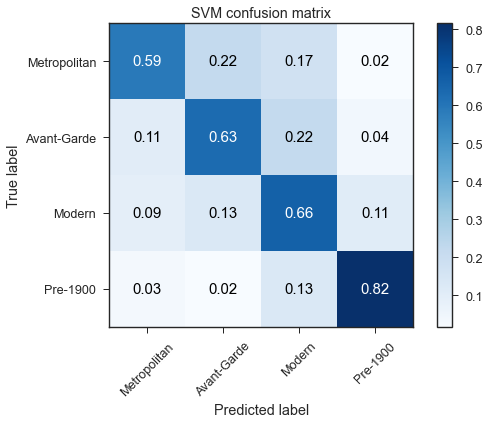

In [69]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

#### Still overfit but nearly a 10% increase in our test predictions!
### Feature importances

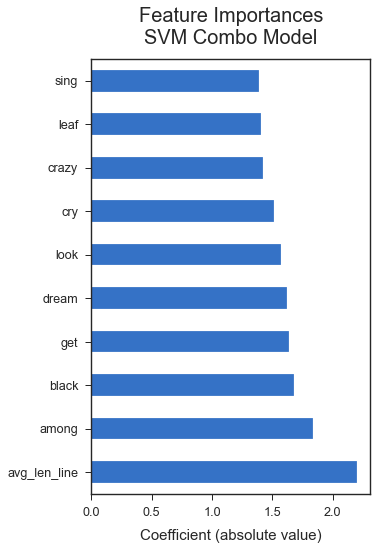

In [86]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

In [94]:
# define vocab
vocab = Counter()
# add all docs to vocab
for poem in X_train.string_cleaned:
    words = poem.split()
    vocab.update(word for word in words)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

28355
[('love', 2218), ('say', 1819), ('day', 1699), ('make', 1656), ('see', 1648), ('eye', 1539), ('know', 1460), ('night', 1434), ('life', 1424), ('man', 1379), ('time', 1333), ('light', 1314), ('old', 1284), ('heart', 1233), ('thing', 1118), ('hand', 1084), ('look', 1072), ('long', 1040), ('still', 1012), ('world', 976), ('take', 973), ('never', 958), ('white', 956), ('sea', 935), ('face', 930), ('let', 917), ('wind', 895), ('sun', 874), ('little', 854), ('even', 846), ('god', 839), ('back', 833), ('men', 827), ('give', 823), ('dream', 823), ('year', 821), ('way', 809), ('thought', 805), ('tree', 793), ('death', 793), ('soul', 785), ('well', 782), ('turn', 767), ('earth', 762), ('away', 758), ('water', 748), ('die', 748), ('head', 743), ('dead', 732), ('air', 730)]


In [95]:
# keep tokens with a min occurrence
min_occurence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurence]
print(len(tokens))

15397


In [96]:
# # uncomment to save
# with gzip.open('data/tokens.pkl', 'wb') as goodbye:
#     pickle.dump(tokens, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/tokens.pkl', 'rb') as hello:
#     tokens = pickle.load(hello)

In [97]:
def clean_string_cleaner(text, vocab):
    words = text.split()
    words = [word for word in words if word in vocab]
    clean_text = ' '.join(words)
    return clean_text

In [98]:
X_train['vocab_string'] = X_train.string_cleaned.apply(lambda x: clean_string_cleaner(x, tokens))
X_test['vocab_string'] = X_test.string_cleaned.apply(lambda x: clean_string_cleaner(x, tokens))

In [99]:

train_docs = X_train.vocab_string
test_docs = X_test.vocab_string

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

In [100]:
# sequence encode
encoded_train_docs = tokenizer.texts_to_sequences(train_docs)

In [101]:


# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_train_docs, maxlen=max_length, padding='post')

In [102]:
# sequence encode
encoded_test_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')

In [103]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

In [80]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
# # CUSTOM ADD
model.add(Dropout(0.2))
# # CUSTOM KERNEL
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
# # CUSTOM ADD
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3861, 50)          724800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 3861, 50)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3859, 32)          4832      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1929, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61728)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                617290    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
__________

In [104]:
# instantiate the encoder
le = LabelEncoder()

# fit and transform the target train set
ytrain = le.fit_transform(y_train)

# transfomr the target test set
ytest = le.transform(y_test)

In [83]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest),
                    verbose=2)

Train on 2931 samples, validate on 1445 samples
Epoch 1/10
 - 11s - loss: 1.3812 - acc: 0.2989 - val_loss: 1.3704 - val_acc: 0.3426
Epoch 2/10
 - 11s - loss: 1.3515 - acc: 0.3323 - val_loss: 1.3493 - val_acc: 0.3536
Epoch 3/10
 - 11s - loss: 1.2842 - acc: 0.3896 - val_loss: 1.3347 - val_acc: 0.3578
Epoch 4/10
 - 11s - loss: 1.1951 - acc: 0.4313 - val_loss: 1.3650 - val_acc: 0.3419
Epoch 5/10
 - 11s - loss: 1.1408 - acc: 0.4446 - val_loss: 1.4127 - val_acc: 0.3654
Epoch 6/10
 - 11s - loss: 1.1082 - acc: 0.4565 - val_loss: 1.4824 - val_acc: 0.3529
Epoch 7/10
 - 11s - loss: 1.0643 - acc: 0.4691 - val_loss: 1.5949 - val_acc: 0.3661
Epoch 8/10
 - 11s - loss: 1.0575 - acc: 0.4763 - val_loss: 1.5809 - val_acc: 0.3543
Epoch 9/10
 - 12s - loss: 1.0457 - acc: 0.4916 - val_loss: 1.7831 - val_acc: 0.3626
Epoch 10/10
 - 13s - loss: 1.0261 - acc: 0.5145 - val_loss: 1.7985 - val_acc: 0.3737


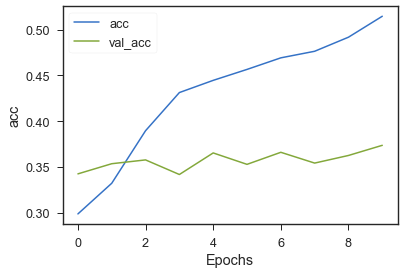

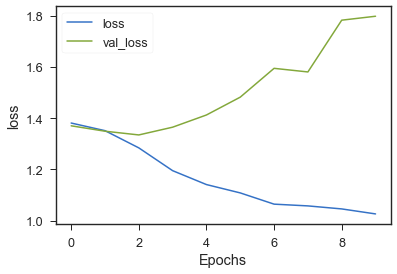

In [84]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
max_features = 1000
maxlen = 201
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [109]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
# # CUSTOM ADD
model.add(Dropout(0.25))
# # CUSTOM KERNEL
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
# # CUSTOM ADD
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 3868, 100)         1539800   
_________________________________________________________________
dropout_9 (Dropout)          (None, 3868, 100)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3864, 128)         64128     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1932, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 247296)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2472970   
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
__________

In [112]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='data/best_model.h5', monitor='val_loss', save_best_only=True)]

In [114]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest), callbacks=callbacks,
                    verbose=2)

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 65s - loss: 1.4000 - acc: 0.3221 - val_loss: 1.3504 - val_acc: 0.3803
Epoch 2/10
 - 84s - loss: 1.2755 - acc: 0.3818 - val_loss: 1.2180 - val_acc: 0.4570
Epoch 3/10
 - 82s - loss: 1.0894 - acc: 0.4805 - val_loss: 1.1563 - val_acc: 0.4799
Epoch 4/10
 - 84s - loss: 0.9192 - acc: 0.5551 - val_loss: 1.1758 - val_acc: 0.5101
Epoch 5/10
 - 86s - loss: 0.7930 - acc: 0.5945 - val_loss: 1.2566 - val_acc: 0.4835


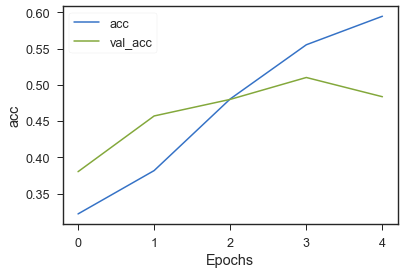

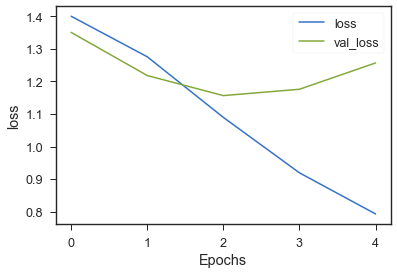

In [115]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [83]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest),
                    verbose=2)

Train on 2931 samples, validate on 1445 samples
Epoch 1/10
 - 11s - loss: 1.3812 - acc: 0.2989 - val_loss: 1.3704 - val_acc: 0.3426
Epoch 2/10
 - 11s - loss: 1.3515 - acc: 0.3323 - val_loss: 1.3493 - val_acc: 0.3536
Epoch 3/10
 - 11s - loss: 1.2842 - acc: 0.3896 - val_loss: 1.3347 - val_acc: 0.3578
Epoch 4/10
 - 11s - loss: 1.1951 - acc: 0.4313 - val_loss: 1.3650 - val_acc: 0.3419
Epoch 5/10
 - 11s - loss: 1.1408 - acc: 0.4446 - val_loss: 1.4127 - val_acc: 0.3654
Epoch 6/10
 - 11s - loss: 1.1082 - acc: 0.4565 - val_loss: 1.4824 - val_acc: 0.3529
Epoch 7/10
 - 11s - loss: 1.0643 - acc: 0.4691 - val_loss: 1.5949 - val_acc: 0.3661
Epoch 8/10
 - 11s - loss: 1.0575 - acc: 0.4763 - val_loss: 1.5809 - val_acc: 0.3543
Epoch 9/10
 - 12s - loss: 1.0457 - acc: 0.4916 - val_loss: 1.7831 - val_acc: 0.3626
Epoch 10/10
 - 13s - loss: 1.0261 - acc: 0.5145 - val_loss: 1.7985 - val_acc: 0.3737


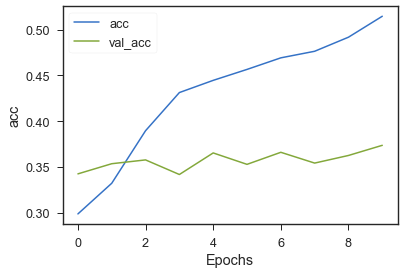

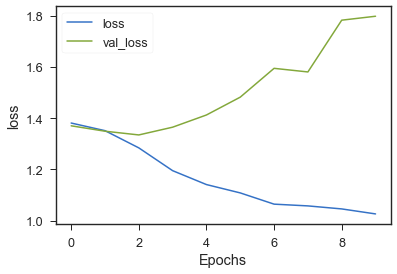

In [84]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
max_features = 1000
maxlen = 201
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [116]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 150, input_length=max_length))
# # CUSTOM ADD
model.add(Dropout(0.25))
# # CUSTOM KERNEL
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(10, activation='relu', kernel_regularizer='l1'))
# # CUSTOM ADD
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 3868, 150)         2309700   
_________________________________________________________________
dropout_11 (Dropout)         (None, 3868, 150)         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3864, 128)         96128     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 966, 128)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 123648)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1236490   
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
__________

In [117]:
# Set callback functions to early stop training and save the best model so far
callbacks2 = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='data/best_model2.h5', monitor='val_loss', save_best_only=True)]

In [118]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest), callbacks=callbacks2,
                    verbose=2)

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 85s - loss: 5.2685 - acc: 0.2956 - val_loss: 2.9161 - val_acc: 0.3044
Epoch 2/10
 - 101s - loss: 2.9124 - acc: 0.3285 - val_loss: 2.8898 - val_acc: 0.3026
Epoch 3/10
 - 100s - loss: 2.8074 - acc: 0.3860 - val_loss: 2.7690 - val_acc: 0.4223
Epoch 4/10
 - 103s - loss: 2.7172 - acc: 0.4625 - val_loss: 2.7368 - val_acc: 0.4360
Epoch 5/10
 - 104s - loss: 2.5609 - acc: 0.5308 - val_loss: 2.8180 - val_acc: 0.4442
Epoch 6/10
 - 135s - loss: 2.4080 - acc: 0.6402 - val_loss: 2.7764 - val_acc: 0.4616
Epoch 7/10
 - 150s - loss: 2.2885 - acc: 0.7118 - val_loss: 2.9479 - val_acc: 0.4561


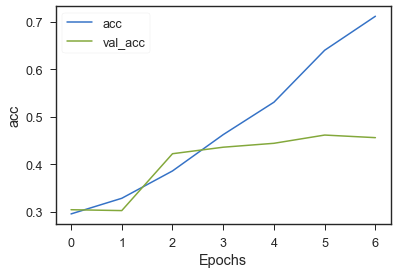

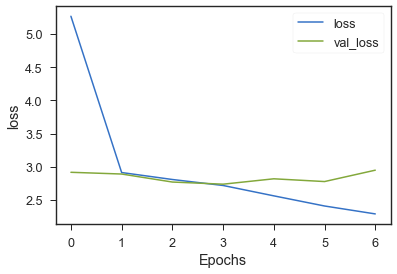

In [119]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Pre-trained word embeddings - GloVe
#### The following code borrows heavily from https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

In [7]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/Users/p.szymo/Documents/word_embeddings/glove6b/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Prepare text data for sequencing

In [11]:
# for this, we'll be using raw poems, so assign those to respective variables
train_docs_raw = X_train.string_titled
test_docs_raw = X_test.string_titled

# create the tokenizer
tokenizer = Tokenizer()

# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs_raw)

# converting text into integer sequences
X_train_seq = tokenizer.texts_to_sequences(train_docs_raw) 
X_test_seq = tokenizer.texts_to_sequences(test_docs_raw)

# compute the length of the longest poem, so we can use that as the maxlen of the sequences
maxlen = max([len(poem.split()) for poem in train_docs_raw])

# padding to prepare sequences of same length
X_train_seq = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_seq = pad_sequences(X_test_seq, maxlen=maxlen)

In [14]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

46438

#### Assign each token to its corresponding pretrained vector

In [15]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Convert target classes to floats

In [19]:
# instantiate the encoder
le = LabelEncoder()

# fit and transform the target train set
y_train_le = le.fit_transform(y_train)

# transfomr the target test set
y_test_le = le.transform(y_test)

### Build a model - CNN

In [26]:
model_cnn = Sequential()

# embedding layer
model_cnn.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)) 

# dropout layer
model_cnn.add(Dropout(0.2))

# cnn layer
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# maxpooling
model_cnn.add(MaxPooling1D())

# flatten
model_cnn.add(Flatten())

# dense layer (with another dropout)
model_cnn.add(Dense(10, activation='relu')) 
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(4, activation='softmax'))

# add loss function, metrics, optimizer
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)  
mc = ModelCheckpoint('data/best_model_pretrained.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

# print summary of model
print(model_cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 7408, 300)         13931400  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7408, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7404, 128)         192128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3702, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 473856)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                4738570   
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
__________

#### Train that model

In [27]:
history = model_cnn.fit(np.array(X_train_seq), np.array(y_train_le), 
                    batch_size=128, epochs=10, 
                    validation_data=(np.array(X_test_seq), np.array(y_test_le)), 
                    verbose=2, callbacks=[es, mc])

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 269s - loss: 1.4164 - acc: 0.2971 - val_loss: 1.3834 - val_acc: 0.3044

Epoch 00001: val_acc improved from -inf to 0.30439, saving model to data/best_model_pretrained.h5
Epoch 2/10
 - 301s - loss: 1.3962 - acc: 0.2934 - val_loss: 1.3781 - val_acc: 0.2971

Epoch 00002: val_acc did not improve from 0.30439
Epoch 3/10
 - 314s - loss: 1.3892 - acc: 0.2940 - val_loss: 1.4109 - val_acc: 0.3007

Epoch 00003: val_acc did not improve from 0.30439
Epoch 4/10
 - 341s - loss: 1.3926 - acc: 0.2965 - val_loss: 1.3749 - val_acc: 0.2980

Epoch 00004: val_acc did not improve from 0.30439
Epoch 5/10
 - 337s - loss: 1.3816 - acc: 0.2928 - val_loss: 1.3822 - val_acc: 0.2925

Epoch 00005: val_acc did not improve from 0.30439
Epoch 6/10
 - 332s - loss: 1.3812 - acc: 0.2928 - val_loss: 1.3818 - val_acc: 0.2925

Epoch 00006: val_acc did not improve from 0.30439
Epoch 7/10
 - 394s - loss: 1.3813 - acc: 0.2925 - val_loss: 1.3815 - val_acc: 0.2925

Ep

In [28]:
X_train_seq

array([[   0,    0,    0, ...,   23, 1846,  121],
       [   0,    0,    0, ...,   25,   37,   64],
       [   0,    0,    0, ...,  305,   36, 1848],
       ...,
       [   0,    0,    0, ..., 4032, 2590, 8742],
       [   0,    0,    0, ...,  995,    2, 1262],
       [   0,    0,    0, ...,  249, 6367,  556]], dtype=int32)

In [29]:
history = model_cnn.fit(np.array(X_train_seq), np.array(y_train_le), 
                        validation_data=(np.array(X_test_seq), np.array(y_test_le)), 
                        epochs=10, verbose=2, callbacks=[es, mc])

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 326s - loss: 1.3806 - acc: 0.2928 - val_loss: 1.3811 - val_acc: 0.2925

Epoch 00001: val_acc did not improve from 0.30439
Epoch 2/10
 - 288s - loss: 1.3802 - acc: 0.2928 - val_loss: 1.3808 - val_acc: 0.2925

Epoch 00002: val_acc did not improve from 0.30439
Epoch 3/10
 - 266s - loss: 1.3802 - acc: 0.2928 - val_loss: 1.3808 - val_acc: 0.2925

Epoch 00003: val_acc did not improve from 0.30439
Epoch 4/10
 - 255s - loss: 1.3801 - acc: 0.2928 - val_loss: 1.3808 - val_acc: 0.2925

Epoch 00004: val_acc did not improve from 0.30439
Epoch 5/10
 - 301s - loss: 1.3801 - acc: 0.2928 - val_loss: 1.3807 - val_acc: 0.2925

Epoch 00005: val_acc did not improve from 0.30439
Epoch 6/10
 - 365s - loss: 1.3801 - acc: 0.2928 - val_loss: 1.3807 - val_acc: 0.2925

Epoch 00006: val_acc did not improve from 0.30439
Epoch 7/10
 - 381s - loss: 1.3804 - acc: 0.2925 - val_loss: 1.3807 - val_acc: 0.2925

Epoch 00007: val_acc did not improve from 0.30439


### Build a model - LSTM

In [24]:
model_lstm = Sequential()

# embedding layer
model_lstm.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)) 

# lstm layer
model_lstm.add(LSTM(128, return_sequences=True, dropout=0.2))

# global maxpooling
model_lstm.add(GlobalMaxPooling1D())

# dense Layer
model_lstm.add(Dense(64,activation='relu')) 
model_lstm.add(Dense(4,activation='softmax'))

# add loss function, metrics, optimizer
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)  
mc = ModelCheckpoint('data/best_model_pretrained.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

# print summary of model
print(model_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 7408, 300)         13931400  
_________________________________________________________________
lstm_4 (LSTM)                (None, 7408, 128)         219648    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 14,159,564
Trainable params: 228,164
Non-trainable params: 13,931,400
_________________________________________________________________
None


#### Train that model

In [23]:
# history = model_lstm.fit(np.array(X_train_seq), np.array(y_train_le), 
#                     batch_size=128, epochs=10, 
#                     validation_data=(np.array(X_test_seq), np.array(y_test_le)), 
#                     verbose=2, callbacks=[es, mc])